## Data Preparation

This pipeline processes the MIMIC-IV ED dataset via local files or BigQuery integration. 

**Data Sources:**
- ED stays, vitals, triage assessments
- Medication records (Pyxis dispensing & reconciliation) 
- Patient demographics and diagnoses
- Age data derived from anchor years

**Key Processing Steps:**
- Standardization of numerical fields (pain: 0-10 scale, vitals: Float64)
- Race categorization (5 consolidated groups: WHITE, BLACK, ASIAN, HISPANIC, OTHER)
- Temporal feature engineering (admission time, Length of Stay, day of week, hour)
- Missing value handling via nullable integers (Int64)
- Datetime normalization for all temporal fields
- Transport mode simplification (WALK IN, AMBULANCE, OTHER)
- Disposition status categorization (HOME, ADMITTED, OTHER)
- Age calculation adjustments based on ED visit dates

**Output:**
Unified dataframe combining demographics, clinical measurements, and temporal features optimized for modeling. Final dataset includes standardized categorical variables, normalized temporal features, and properly typed numerical fields.


In [22]:
# Standard library imports
import sys
from pathlib import Path
import pandas as pd
from google.oauth2 import service_account
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')  # Suppresses all warnings
# Add parent directory to Python path for local imports
sys.path.append('..')

# Local application imports
from src.mimicdf import MIMICDF
from src.DatePreprocessor import DataPreprocessor

# Configuration
CREDENTIALS_PATH = Path('/home/kasra/Development/config/copper-actor-403003-f084a282499a.json')

def setup_mimic_connection():
    """
    Initialize MIMIC database connection with GCP credentials.
    
    Returns:
        MIMICDF: Configured MIMIC database interface
    """
    credentials = service_account.Credentials.from_service_account_file(CREDENTIALS_PATH)
    return MIMICDF(source='gcp', credentials=credentials)



## Data Loading

In [2]:
# Initialize MIMIC database connection
mimicdf = setup_mimic_connection()
print(mimicdf.__doc__)

Successfully connected to MIMIC-IV ED dataset

MIMICDF (MIMIC Database Interface)

A class to interface with the MIMIC-IV Emergency Department database, supporting both
local demo data and Google BigQuery access.

Available Methods:
    edstays(): Get base cohort from edstays with demographics
    demographics(): Get subject demographics including gender, race, and age
    age(): Get age data for subjects
    diagnosis(): Get diagnosis codes and descriptions
    edstays_time(): Get edstays time series data including day of week and length of stay
    med_records(): Get medication records for a specific stay_id
    medications(): Get combined medication records from pyxis and medrecon
    pyxis(): Get medication dispensing records
    triage(): Get triage assessments
    vitals(): Get vital signs data
    model_data(): Get preprocessed data ready for modeling
    clear_cache(): Clear cached dataframes to free memory

Args:
    source (str): Data source - either 'demo' for local demo dat

## Data Exploration

In [3]:
# load 
edstays_df = mimicdf.edstays()
triage_df = mimicdf.triage()

# merge dataframes
raw_df = pd.merge(edstays_df, triage_df, on=['stay_id', 'subject_id'], how='inner')

# Explore data
print(raw_df.info())
raw_df.describe().T


Table loaded: edstays
Table loaded: triage
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   subject_id         425087 non-null  Int64         
 1   hadm_id            203016 non-null  Int64         
 2   stay_id            425087 non-null  Int64         
 3   intime             425087 non-null  datetime64[us]
 4   outtime            425087 non-null  datetime64[us]
 5   gender             425087 non-null  object        
 6   race               425087 non-null  object        
 7   arrival_transport  425087 non-null  object        
 8   disposition        425087 non-null  object        
 9   temperature        401672 non-null  Float64       
 10  heartrate          407997 non-null  Float64       
 11  resprate           404734 non-null  Float64       
 12  o2sat              404491 non-null  Float64       
 13  s

,count,mean,min,25%,50%,75%,max,std
subject_id,425087.0,15008713.591347,10000032.0,12517890.5,15016278.0,17499003.5,19999987.0,2878486.35271
hadm_id,203016.0,24994954.906682,20000019.0,22489817.5,24999349.5,27493879.25,29999809.0,2888744.751396
stay_id,425087.0,34997352.518205,30000012.0,32497991.5,34993947.0,37503868.5,39999965.0,2888341.541656
intime,425087,2156-05-16 02:13:45.025937,2110-01-11 01:45:00,2136-05-04 20:43:00,2156-05-07 11:21:00,2176-06-22 10:45:00,2212-04-05 23:23:00,NaN
outtime,425087,2156-05-16 09:23:15.002193,2110-01-11 07:04:00,2136-05-05 02:42:00,2156-05-07 14:22:00,2176-06-22 16:47:00,2212-04-06 14:20:00,NaN
temperature,401672.0,98.015046,0.1,97.5,98.0,98.6,986.0,4.008575
heartrate,407997.0,85.079891,1.0,72.0,84.0,96.0,1228.0,18.04169
resprate,404734.0,17.565521,0.0,16.0,18.0,18.0,1820.0,5.485706
o2sat,404491.0,98.471888,0.0,97.0,99.0,100.0,9322.0,17.040807
sbp,406796.0,135.395352,1.0,120.0,133.0,148.0,151103.0,240.956408


In [4]:
# explore missing values
missing_values = raw_df.isnull().sum()
missing_percentage = (missing_values / len(raw_df)) * 100
unique_values = raw_df.nunique()
missing_table = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage': missing_percentage, 'Unique Values': unique_values})
print(missing_table)


                   Missing Count  Missing Percentage  Unique Values
subject_id                     0            0.000000         205504
hadm_id                   222071           52.241306         202441
stay_id                        0            0.000000         425087
intime                         0            0.000000         422817
outtime                        0            0.000000         423227
gender                         0            0.000000              2
race                           0            0.000000             33
arrival_transport              0            0.000000              5
disposition                    0            0.000000              8
temperature                23415            5.508284            517
heartrate                  17090            4.020353            220
resprate                   20353            4.787961             83
o2sat                      20596            4.845126            107
sbp                        18291            4.30


## Data Preprocessing

- **Arrival Transport** → 3 categories:
  ```python
  df['arrival_transport'] = df['arrival_transport'].apply(
      lambda x: 'WALK IN' if x == 'WALK IN'
      else 'AMBULANCE' if x == 'AMBULANCE'
      else 'OTHER'
  )
  ```
  - WALK IN: Direct discharge
  - AMBULANCE: Hospital admission
  - OTHER: Transfers, AMA, etc.

- **Disposition Status** → 3 outcomes:
  ```python
  df['disposition_status'] = df['disposition_status'].apply(
      lambda x: 'HOME' if x == 'HOME'
      else 'ADMITTED' if x == 'ADMITTED'
      else 'OTHER'
  )
  ```
  - HOME: Direct discharge
  - ADMITTED: Hospital admission
  - OTHER: Transfers, AMA, etc.

- **Age Calculation**:
  ```python
  df['age_at_ed'] = df['anchor_age'] + (df['intime'].dt.year - df['anchor_year'])
  df['age_at_ed'] = df['age_at_ed'].astype('Int64')  # Nullable integer
  ```
  - Calculates patient age at ED visit using formula as type Int64

- **Derived Time Features**:
  ```python
  df['day_of_week'] = df['intime'].dt.dayofweek
  df['hour_of_admission'] = df['intime'].dt.hour
  df['length_of_stay'] = (df['outtime'] - df['intime']).dt.total_seconds() / 60
  ```
  - dow: Day of week (categorical)
  - hour of admission (0-23)
  - lOS_minutes: Length of stay (minutes)

- **Standardized Triage Measurements**:
  ```python
  df['pain'] = df['pain'].apply(map_pain).astype('Int64')
  df['acuity'] = df['acuity'].apply(map_acuity).astype('Int64')
  ```
  - Vitals: Float64 type
  - Pain: 0-10 scale
  - Acuity: Nullable integers

- **Column Cleanup**:
  ```python
  df = df.drop(['intime', 'outtime', 'anchor_year', 'anchor_age', 'hadm_id'], axis=1)
  ```
  - Removes redundant temporal columns
  - Drops intermediate calculation fields
  - Eliminates unnecessary identifiers

In [5]:
ed_data = mimicdf.ed_data()

print(ed_data.info())
ed_data.describe().T


Loading edstays...
Table loaded: edstays
Loading age data...
Table loaded: age
Loading time features...
Table loaded: edstays
Loading triage data...
Table loaded: triage
Processing age calculations...
Calculating ED visit age...
Merging time features...
Merging triage features...
Cleaning up columns...

 Dataframe shape: (2588775, 18) 

Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588775 entries, 0 to 2588774
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   subject_id         Int64  
 1   stay_id            Int64  
 2   gender             object 
 3   race               object 
 4   arrival_transport  object 
 5   disposition        object 
 6   age_at_ed          Int64  
 7   dow                object 
 8   hour               int32  
 9   los_minutes        float64
 10  temperature        Float64
 11  heartrate          Float64
 12  resprate           Float64
 13  o2sat              Float64
 14  sbp          

,count,mean,std,min,25%,50%,75%,max
subject_id,2588775.0,15018457.85657,2787061.859239,10000032.0,12591205.0,15229574.0,17338425.0,19999987.0
stay_id,2588775.0,34992963.319132,2891247.663007,30000012.0,32480611.0,35000450.0,37498498.5,39999965.0
age_at_ed,2480153.0,58.802715,16.729216,18.0,48.0,59.0,70.0,103.0
hour,2588775.0,13.449231,5.985713,0.0,10.0,14.0,18.0,23.0
los_minutes,2588775.0,511.862848,444.522311,-1364.0,262.0,398.0,607.0,29584.166667
temperature,2470322.0,98.045662,8.734565,0.1,97.5,98.0,98.5,986.0
heartrate,2511566.0,86.657782,17.800634,1.0,74.0,86.0,98.0,1228.0
resprate,2486530.0,17.810317,9.990983,0.0,16.0,18.0,18.0,1820.0
o2sat,2485098.0,98.127195,21.456878,0.0,97.0,98.0,100.0,9322.0
sbp,2503402.0,135.388425,119.427815,1.0,119.0,133.0,149.0,151103.0


## Data Transformation

### `DataPreprocessor`

A class that handles cleaning and validation of ED visit measurements based on physiological and statistical rules.

- **clean_blood_pressure()**
   ```python
   # Validates BP readings using physiological rules
   invalid_bp = ~(
       (data['dbp'] > 0) & 
       (data['sbp'] > 0) & 
       (data['dbp'] <= 300) & 
       (data['sbp'] <= 350) &
       (data['dbp'] < data['sbp'])
   )
   ```
   - Ensures DBP and SBP are positive
   - Sets upper limits: DBP ≤ 300, SBP ≤ 350
   - Validates DBP < SBP relationship

- **clean_vital_signs()**
   ```python
   # O2 saturation: 0-100%
   data.loc[~((data['o2sat'] >= 0) & (data['o2sat'] <= 100)), 'o2sat'] = np.nan
   
   # Respiratory rate: 0-300 breaths/min
   data.loc[~((data['resprate'] > 0) & (data['resprate'] < 300)), 'resprate'] = np.nan
   
   # Temperature: 50-120°F
   data.loc[~((data['temperature'] > 50) & (data['temperature'] < 120)), 'temperature'] = np.nan
   
   # Heart rate: 0-300 beats/min
   data.loc[~((data['heartrate'] > 0) & (data['heartrate'] < 300)), 'heartrate'] = np.nan
   ```
   - `clean_o2sat()`: Validates range [0-100]%
   - `clean_resprate()`: Ensures (0-300) breaths/min
   - `clean_temperature()`: Range (50-120)°F
   - `clean_heartrate()`: Range (0-300) beats/min

- **clean_los()**
   ```python
   # Ensure positive length of stay
   data.loc[~(data['los_minutes'] > 0), 'los_minutes'] = np.nan
   ```
   - Ensures positive length of stay values
   - Converts invalid durations to NaN


In [6]:
# Data Preprocessing
preprocessor = DataPreprocessor(mimicdf)
clean_data = preprocessor.prepare_data()

print(clean_data.info())
clean_data.describe().T


Loading edstays...
Table loaded: edstays
Loading age data...
Table loaded: age
Loading time features...
Table loaded: edstays
Loading triage data...
Table loaded: triage
Processing age calculations...
Calculating ED visit age...
Merging time features...
Merging triage features...
Cleaning up columns...

 Dataframe shape: (2588775, 18) 

Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588775 entries, 0 to 2588774
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   subject_id         Int64  
 1   stay_id            Int64  
 2   gender             object 
 3   race               object 
 4   arrival_transport  object 
 5   disposition        object 
 6   age_at_ed          Int64  
 7   dow                object 
 8   hour               int32  
 9   los_minutes        float64
 10  temperature        Float64
 11  heartrate          Float64
 12  resprate           Float64
 13  o2sat              Float64
 14  sbp          

,count,mean,std,min,25%,50%,75%,max
subject_id,2588775.0,15018457.85657,2787061.859239,10000032.0,12591205.0,15229574.0,17338425.0,19999987.0
stay_id,2588775.0,34992963.319132,2891247.663007,30000012.0,32480611.0,35000450.0,37498498.5,39999965.0
age_at_ed,2480153.0,58.802715,16.729216,18.0,48.0,59.0,70.0,103.0
hour,2588775.0,13.449231,5.985713,0.0,10.0,14.0,18.0,23.0
los_minutes,2588688.0,511.885655,444.506008,1.0,262.0,398.0,607.0,29584.166667
temperature,2466790.0,98.052861,1.037024,56.0,97.5,98.0,98.5,111.4
heartrate,2511534.0,86.646825,17.523991,1.0,74.0,86.0,98.0,256.0
resprate,2486454.0,17.758738,2.80055,1.0,16.0,18.0,18.0,209.0
o2sat,2484765.0,97.998919,2.591082,0.0,97.0,98.0,100.0,100.0
sbp,2499371.0,134.984007,23.750205,1.0,119.0,133.0,149.0,312.0


## Data Visualization


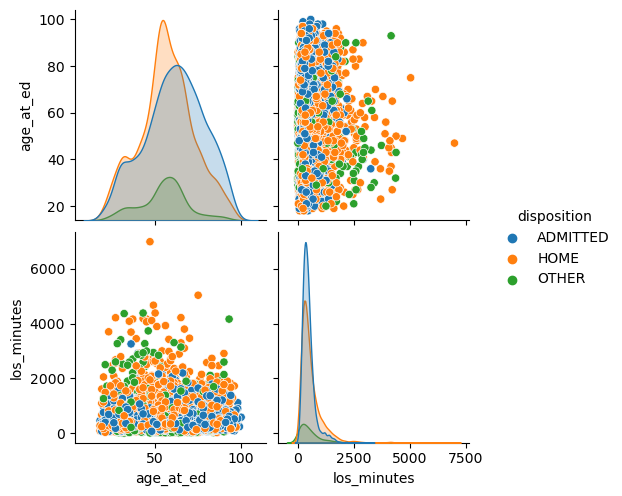

In [25]:


column_groups = {
    'target': ['age_at_ed', 'los_minutes', 'temperature', 'resprate', 'heartrate', 
               'dbp', 'sbp', 'o2sat', 'pain', 'acuity', 'arrival_transport', 'disposition'],
    'vitals': ['temperature', 'resprate', 'heartrate', 'dbp', 'sbp', 'o2sat'],
    'admission': ['age_at_ed', 'los_minutes', 'arrival_transport', 'disposition'],
    'demographic': ['gender', 'race', 'age_at_ed']
}

graph_df = clean_data.dropna().copy()

# plot vitals
# sns.pairplot(
#     graph_df[column_groups['vitals']].sample(1000),
#     diag_kind='kde'  # Optional: adds kernel density plots on diagonal
# )
# plt.show()

sns.pairplot(
    graph_df[column_groups['admission']].sample(10000),
    hue='disposition',
    diag_kind='kde'  # Optional: adds kernel density plots on diagonal
)
plt.show()
